# Project question 2 - Which driver beat their teammates the hardest over their career in Formula One?

## 1. Importing data

In [3]:
import pandas as pd
import numpy as np

results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')
drivers = pd.read_csv('drivers.csv')
qualifying = pd.read_csv('qualifying.csv')
qualifying

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236
...,...,...,...,...,...,...,...,...,...
9810,9868,1110,848,3,23,16,2:00.314,\N,\N
9811,9869,1110,855,51,24,17,2:00.832,\N,\N
9812,9870,1110,858,3,2,18,2:01.535,\N,\N
9813,9871,1110,817,213,3,19,2:02.159,\N,\N


## 2. Preparing data

Preparing training data as well as adding useful features such as a ratio of points to teammate. We once again run into the issue of points systems changing over time, so we will normalize by dividing by total points scored in a race.

In [199]:
def get_results(year1, year2=None):
    if year2 is None:
        races_data = races.loc[races['year'] == year1]
    else:
        races_data = races.loc[(races['year'] >= year1) & (races['year'] <= year2)]

    races_year_circuit_data = pd.concat([races_data['raceId'], races_data['circuitId'], races_data['time']], axis=1)
    results_data = results.loc[(results['raceId'].isin(races_data['raceId']))]
    results_data = pd.merge(results_data, races_year_circuit_data, on='raceId')
    results_data = results_data.drop(columns=['time_x', 'positionText', 'resultId', 'fastestLap'])
    results_data = results_data.replace('\\N', 0)
    results_data['time_y'] = results_data['time_y'].apply(find_time)
    results_data['fastestLapTime'] = results_data['fastestLapTime'].apply(find_milliseconds)
    # Convert everything to numeric
    results_data = results_data.apply(pd.to_numeric, errors='coerce')

    # Add a column of total points scored in that race by all drivers
    results_data['total_points_race'] = results_data.groupby('raceId')['points'].transform('sum')

    # Add a year column from races.csv
    results_data = pd.merge(results_data, races[['raceId', 'year']], on='raceId')

    return results_data


def get_driver_results(driverId, year1=1950, year2=2023):
    results_data = get_results(year1, year2)
    driver_results = results_data.loc[results_data['driverId'] == driverId].copy()

    teammate_results = results_data.loc[results_data['constructorId'] == driver_results['constructorId'].iloc[0]].copy()
    teammate_results = teammate_results.loc[teammate_results['driverId'] != driverId]
    teammate_results = teammate_results.drop(columns=['driverId', 'constructorId', 'time_y', 'circuitId', 'total_points_race'])

    for column in teammate_results.columns:
        if column != 'driverId' and column != 'constructorId' and column != 'raceId':
            teammate_results.rename(columns={column: 'teammate_' + column}, inplace=True)

    driver_results = pd.merge(driver_results, teammate_results, on='raceId', how='left')

    # Calculate the difference in points between the driver and the teammate
    driver_results['points_difference'] = driver_results['points'] - driver_results['teammate_points']

    # Add a column of the difference in points divided by the total points scored in that race
    driver_results['points_difference_ratio'] = driver_results['points_difference'] / driver_results['total_points_race']

    return driver_results

def get_all_driver_results():
    # Get all driver results
    all_driver_results = pd.DataFrame()
    for driverId in drivers['driverId']:
        driver_results = get_driver_results(driverId)
        all_driver_results = pd.concat([all_driver_results, driver_results])
    # Remove all rows with NaN
    return all_driver_results

def find_time(time):
    if (time == 0):
        return 0
    hours, minutes, seconds = str(time).split(':')
    return (int(hours) * 100) + int(minutes)

all_results = get_all_driver_results()

## 3. Making the model

In [200]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

all_results = all_results.dropna()

X = all_results.drop(columns=['points_difference','points','teammate_points','points_difference_ratio', 'position', 'teammate_position', 'positionOrder', 'teammate_positionOrder'])
y = all_results['points_difference_ratio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the random forest regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)
print("Mean Squared Error:", mse, "R2 Score:", r2)

Mean Squared Error: 0.0023815706701150277 R2 Score: 0.8214862780815627


In [214]:
# Find the driver with the highest predicted points difference
max_index = np.argmax(y_pred)

max_driver = X_test.iloc[max_index]

# Find the driver with the highest actual points difference
max_index = np.argmax(y_test)

max_driver = X_test.iloc[max_index]

print(max_driver)

raceId                          225.0
driverId                         71.0
constructorId                     3.0
number                            5.0
grid                              1.0
laps                             71.0
milliseconds                6592976.0
rank                              0.0
fastestLapTime                    0.0
fastestLapSpeed                   0.0
statusId                          1.0
circuitId                        18.0
time_y                            0.0
total_points_race                26.0
year                           1996.0
teammate_number                  11.0
teammate_grid                     2.0
teammate_laps                    59.0
teammate_milliseconds             0.0
teammate_rank                     0.0
teammate_fastestLapTime           0.0
teammate_fastestLapSpeed          0.0
teammate_statusId                20.0
teammate_year                  1996.0
Name: 69, dtype: float64


The driver who was predictd to dominate their teammate the most was Damon Hill at the 1996 Brazilian Grand Prix, where his teammate failed to finish. 

## Turning race predictions into season predictions

In [224]:
# Calculate the total points difference for each driver over the season
season_results = all_results.groupby(['driverId', 'year']).sum()
season_results.reset_index(inplace=True)

# Split the data into training and testing sets
X_season = season_results.drop(columns=['points_difference_ratio'])
y_season = season_results['points_difference_ratio']
X_season_train, X_season_test, y_season_train, y_season_test = train_test_split(X_season, y_season, test_size=0.2, random_state=42)

# Create the random forest regressor model for the season
season_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the season model
season_model.fit(X_season_train, y_season_train)

# Make predictions on the test set for the season
y_season_pred = season_model.predict(X_season_test)

# Evaluate the season model
mse_season = mean_squared_error(y_season_test, y_season_pred)
r2_season = season_model.score(X_season_test, y_season_test)
print("Mean Squared Error (Season):", mse_season, "R2 Score (Season):", r2_season)

Mean Squared Error (Season): 0.05665811930293425 R2 Score (Season): 0.9743688973993127


## Finding the driver with the highest predicted season result

In [227]:
max_index = np.argmax(y_season_pred)
max_driver = X_season_test.iloc[max_index]
print(max_driver)

# Find who this driver is
driver = drivers.loc[drivers['driverId'] == max_driver['driverId']]
print(driver)

driverId                          579.0
year                             1957.0
raceId                          42127.0
constructorId                    5670.0
number                            370.0
grid                              114.0
position                           69.0
positionOrder                     147.0
points                            359.0
laps                             3529.0
milliseconds                524773200.0
rank                                0.0
fastestLapTime                      0.0
fastestLapSpeed                     0.0
statusId                           78.0
circuitId                        1677.0
time_y                              0.0
total_points_race                1296.0
teammate_number                   886.0
teammate_grid                     551.0
teammate_position                 166.0
teammate_positionOrder            588.0
teammate_points                    32.0
teammate_laps                    2229.0
teammate_milliseconds        59265500.0


Juan Manuel Fangio in 1957 is the one who beat his teammate the worst.

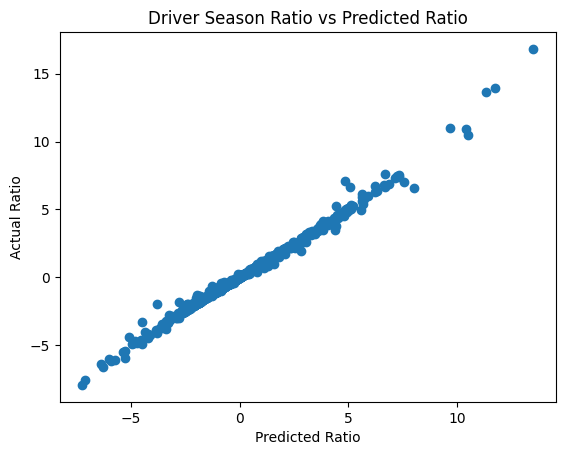

In [232]:
import matplotlib.pyplot as plt

# Get the predicted season ratios
predicted_ratios = season_model.predict(X_season)

# Create the scatter plot
plt.scatter(predicted_ratios, y_season)

# Add labels and title
plt.xlabel('Predicted Ratio')
plt.ylabel('Actual Ratio')
plt.title('Driver Season Ratio vs Predicted Ratio')

# Show the plot
plt.show()
